In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('./src/analysis')
sys.path.append('./src/data_handling')
sys.path.append('./src/modeling')
sys.path.append('./src/prediction')
sys.path.append('./src/visualization')
from analyzer import FeatureAnalyzer
from selector import FeatureSelector
from aggregator import DataAggregator
from feature_engineer import BatteryFeatureEngineer
from reader import BatteryDataReader
from cross_validator import CrossValidator
from evaluator import ModelEvaluator
from trainer import ModelTrainer
from predictor import Predictor
from visualizer import ResultVisualizer


In [2]:
battery_ids = ['B0005', 'B0006', 'B0007', 'B0018']
ACTUAL_DATA_DIR = "./dataset/"

# Update config for feature engineering
fe_configuration = {
    # Update config
}

# Init object
aggregator_df = DataAggregator(
    battery_ids=battery_ids,
    data_dir=ACTUAL_DATA_DIR,
    fe_config=fe_configuration
)

In [3]:
# Aggregator data
aggregator_df.aggregate(force_rerun=True)

# Get data aggregator
df_combined = aggregator_df.get_combined_data()

# Check data combined
df_combined.head()


--- Starting Data Aggregation for Batteries: ['B0018', 'B0007', 'B0005', 'B0006'] ---


Aggregating Batteries:   0%|          | 0/4 [00:00<?, ?it/s]


--- Processing: B0018 ---
--- Loading data for battery: B0018 ---
  Successfully loaded: capacity_B0018.csv
  Successfully loaded: charge_B0018.csv
  Successfully loaded: discharge_B0018.csv
--- Data loading process completed for B0018 ---
  Ensuring numeric types for B0018...
--- Starting Feature Engineering process for B0018 ---
  Calculating SOH/RUL for B0018...
    Note: Battery B0018 did not reach EoL threshold (1.30 Ah). Using 133 for RUL.
  Engineering discharge features for B0018...


  Engineering charge features for B0018...


Aggregating Batteries:  25%|██▌       | 1/4 [00:00<00:01,  2.08it/s]

  Merging features for B0018...
  Handling NaNs for B0018...
--- Feature Engineering process finished for B0018 ---
  Successfully processed B0018. Shape: (132, 13)

--- Processing: B0007 ---
--- Loading data for battery: B0007 ---
  Successfully loaded: capacity_B0007.csv
  Successfully loaded: charge_B0007.csv
  Successfully loaded: discharge_B0007.csv
--- Data loading process completed for B0007 ---
  Ensuring numeric types for B0007...
--- Starting Feature Engineering process for B0007 ---
  Calculating SOH/RUL for B0007...
    Note: Battery B0007 did not reach EoL threshold (1.32 Ah). Using 169 for RUL.
  Engineering discharge features for B0007...


  Engineering charge features for B0007...


Aggregating Batteries:  50%|█████     | 2/4 [00:01<00:01,  1.55it/s]

  Merging features for B0007...
  Handling NaNs for B0007...
--- Feature Engineering process finished for B0007 ---
  Successfully processed B0007. Shape: (168, 13)

--- Processing: B0005 ---
--- Loading data for battery: B0005 ---
  Successfully loaded: capacity_B0005.csv
  Successfully loaded: charge_B0005.csv
  Successfully loaded: discharge_B0005.csv
--- Data loading process completed for B0005 ---
  Ensuring numeric types for B0005...
--- Starting Feature Engineering process for B0005 ---
  Calculating SOH/RUL for B0005...
  Engineering discharge features for B0005...


  Engineering charge features for B0005...


Aggregating Batteries:  75%|███████▌  | 3/4 [00:01<00:00,  1.50it/s]

  Merging features for B0005...
  Handling NaNs for B0005...
--- Feature Engineering process finished for B0005 ---
  Successfully processed B0005. Shape: (168, 13)

--- Processing: B0006 ---
--- Loading data for battery: B0006 ---
  Successfully loaded: capacity_B0006.csv
  Successfully loaded: charge_B0006.csv
  Successfully loaded: discharge_B0006.csv
--- Data loading process completed for B0006 ---
  Ensuring numeric types for B0006...
--- Starting Feature Engineering process for B0006 ---
  Calculating SOH/RUL for B0006...
  Engineering discharge features for B0006...


  Engineering charge features for B0006...


Aggregating Batteries: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

  Merging features for B0006...
  Handling NaNs for B0006...
--- Feature Engineering process finished for B0006 ---
  Successfully processed B0006. Shape: (168, 13)


Aggregating Batteries: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


--- Concatenating data from all processed batteries ---
Combined DataFrame shape: (636, 13)
Unique batteries in combined data: ['B0018' 'B0007' 'B0005' 'B0006']

--- Performing final NaN check and fill on combined data ---
No NaNs found in the combined data after individual processing.
--- Data Aggregation Finished ---


,cycle,capacity,SOH,RUL,Discharge_V_median,Discharge_V_skew,Discharge_T_delta,Discharge_T_std,Charge_T_std,Time_CC_phase,Time_CV_phase,CV_I_end,battery_id
0,1,1.855005,100.000000,132,3.526933,-0.947780,14.282283,3.393883,0.820400,296.578,7411.750,0.004135,B0018
1,2,1.843196,99.363398,131,3.533510,-1.043131,13.835093,3.279763,1.268922,2796.594,7523.328,-0.001571,B0018
2,3,1.839602,99.169669,130,3.535711,-1.050840,13.784999,3.267322,1.312674,2806.203,7533.282,0.001311,B0018
3,4,1.830674,98.688364,129,3.535111,-1.013628,13.834936,3.290899,1.318874,2788.610,7554.031,0.001190,B0018
4,5,1.832700,98.797614,128,3.540578,-1.038804,13.796394,3.303798,1.203835,2750.344,7581.500,-0.001253,B0018


In [4]:
df_X_train_real = []
df_soh_b0005 = pd.read_csv('soh_predict_b0005.csv')
df_soh_b0006 = pd.read_csv('soh_predict_b0006.csv')
df_soh_b0007 = pd.read_csv('soh_predict_b0007.csv')
df_soh_b0018 = pd.read_csv('soh_predict_b0018.csv')
df_X_train_real.append(df_soh_b0005)
df_X_train_real.append(df_soh_b0006)
df_X_train_real.append(df_soh_b0007)
df_X_train_real.append(df_soh_b0018)

In [5]:
# Tạo mapping giữa battery_id và DataFrame chứa SOH tương ứng
soh_data = {
    'B0005': df_soh_b0005,
    'B0006': df_soh_b0006,
    'B0007': df_soh_b0007,
    'B0018': df_soh_b0018,
}

for battery_id, soh_df in soh_data.items():
    mask = df_combined['battery_id'] == battery_id
    indices = df_combined[mask].index
    
    soh_values = soh_df.iloc[:, 1].values  # Cột chứa giá trị SOH, giả sử là cột thứ 2

    # Kiểm tra độ dài trước khi gán
    if len(indices) != len(soh_values):
        print(f"❌ Lỗi: {battery_id} có {len(indices)} dòng trong df_scaled nhưng {len(soh_values)} giá trị SOH")
        continue

    df_combined.loc[indices, 'SOH'] = soh_values

In [6]:
def replace_outlier(df_processed,column_names, thresholds):
    for column_name, threshold in zip(column_names, thresholds):
        indices_below_threshold = df_processed.index[df_processed[column_name] < threshold].tolist()

        print(f"\nCác index có giá trị < {threshold}: {indices_below_threshold}")

        for idx in indices_below_threshold:
            # Kiểm tra xem có phải là hàng cuối cùng không
            if idx < len(df_processed) - 1:
                value_after = df_processed.loc[idx + 1, column_name]
                print(f" - Tại index {idx}, giá trị gốc là {df_processed.loc[idx, column_name]}.Thay bằng : {value_after}")
                df_processed.loc[idx, column_name] = value_after

In [7]:
df_combined_copy = df_combined.copy()

In [10]:
replace_outlier(df_combined_copy, ['Time_CV_phase', 'Time_CC_phase', 'Charge_T_std'],[6000, 500, 0.7])


Các index có giá trị < 6000: []

Các index có giá trị < 500: []

Các index có giá trị < 0.7: []


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [12]:
features_to_scale = ['Discharge_V_median', 'Discharge_V_skew','Discharge_T_delta','Discharge_T_std','Charge_T_std','Time_CC_phase'
                    ,'Time_CV_phase']
df_scaled = df_combined_copy.copy()
# --- A. StandardScaler ---
print("\n--- Sử dụng StandardScaler ---")
scaler_std = StandardScaler()
# Fit và transform trực tiếp trên các cột đã chọn của df_scaled
df_scaled[features_to_scale] = scaler_std.fit_transform(df_scaled[features_to_scale])
print("DataFrame sau khi chuẩn hóa bằng StandardScaler:")
print(df_scaled)
# In ra mean và std của các cột đã chuẩn hóa để kiểm tra
print("Mô tả thống kê các cột đã chuẩn hóa (StandardScaler):")
print(df_scaled[features_to_scale].describe().round(2)) # Mean gần 0, std gần 1


--- Sử dụng StandardScaler ---
DataFrame sau khi chuẩn hóa bằng StandardScaler:
     cycle  capacity        SOH  RUL  Discharge_V_median  Discharge_V_skew  \
0        1  1.855005  93.495901  132            0.693080         -0.394659   
1        2  1.843196  94.294280  131            0.841751         -0.625156   
2        3  1.839602  94.444685  130            0.891500         -0.643792   
3        4  1.830674  94.275822  129            0.877937         -0.553836   
4        5  1.832700  94.227824  128            1.001529         -0.614698   
..     ...       ...        ...  ...                 ...               ...   
631    164  1.153818  62.244098    0           -1.646761          0.715677   
632    165  1.164401  62.168670    0           -1.637661          0.785870   
633    166  1.158797  62.000871    0           -1.679333          0.545064   
634    167  1.174975  62.724622    0           -1.532629          0.534614   
635    168  1.185675  63.593692    0           -1.352654     

FeatureAnalyzer initialized with data shape: (636, 13)
Correlation matrix not calculated yet. Calculating with default settings...

Calculating correlation matrix (method='pearson', numeric_only=True)...
  Using 12 numeric columns for correlation.
  Correlation matrix calculated successfully.

Plotting correlation heatmap...


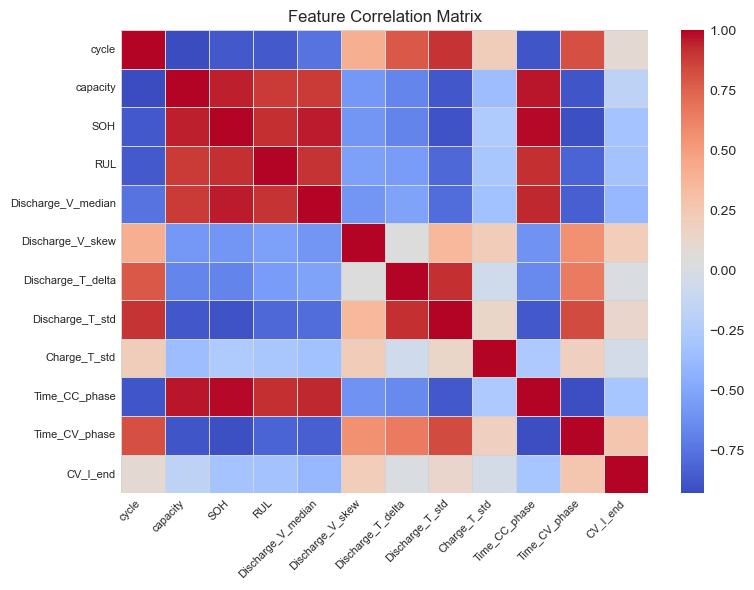

In [13]:
# Init object analyzer
analyzer = FeatureAnalyzer(combined_data=df_scaled)

# Plot heatmap
analyzer.plot_correlation_heatmap(figsize=(8, 6), annot=False)



Correlation with RUL:
Top 5 Positive/Negative:
SOH                   0.915383
Time_CC_phase         0.912891
Discharge_V_median    0.904691
capacity              0.880138
Charge_T_std         -0.288949
Name: RUL, dtype: float64
Discharge_V_skew    -0.532074
Discharge_T_delta   -0.559170
Discharge_T_std     -0.802010
Time_CV_phase       -0.820488
cycle               -0.866456
Name: RUL, dtype: float64

Plotting correlation with target: 'RUL'...


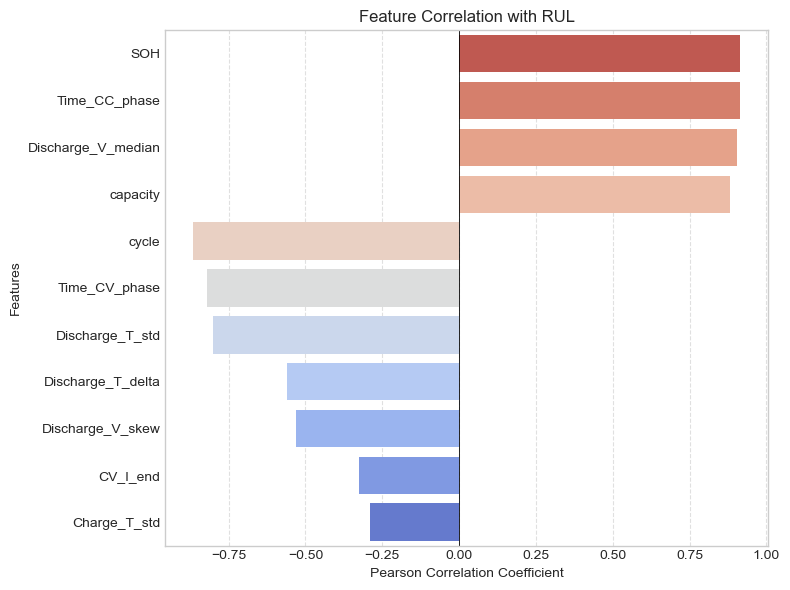

In [14]:
rul_correlation = analyzer.get_correlation_with_target('RUL')
if rul_correlation is not None:
    print("\nCorrelation with RUL:")
    print("Top 5 Positive/Negative:")
    print(rul_correlation.drop('RUL', errors='ignore').head())
    print(rul_correlation.drop('RUL', errors='ignore').tail())
    analyzer.plot_correlation_with_target('RUL', sort_by_abs=True, figsize=(8,6))

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    LeaveOneGroupOut, GridSearchCV, GroupKFold, KFold
)
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C_kernel, WhiteKernel
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
import matplotlib.pyplot as plt
import warnings
import time

warnings.filterwarnings('ignore')

In [16]:
df_scaled.head()

,cycle,capacity,SOH,RUL,Discharge_V_median,Discharge_V_skew,Discharge_T_delta,Discharge_T_std,Charge_T_std,Time_CC_phase,Time_CV_phase,CV_I_end,battery_id
0,1,1.855005,93.495901,132,0.693080,-0.394659,-1.091821,-1.276656,-2.664932,1.116843,-0.702269,0.004135,B0018
1,2,1.843196,94.294280,131,0.841751,-0.625156,-1.454951,-1.575723,-1.227088,1.116843,-0.554631,-0.001571,B0018
2,3,1.839602,94.444685,130,0.891500,-0.643792,-1.495628,-1.608328,-1.086832,1.132255,-0.541460,0.001311,B0018
3,4,1.830674,94.275822,129,0.877937,-0.553836,-1.455079,-1.546539,-1.066955,1.104037,-0.514005,0.001190,B0018
4,5,1.832700,94.227824,128,1.001529,-0.614698,-1.486376,-1.512737,-1.435739,1.042661,-0.477659,-0.001253,B0018


# RANDOM FOREST

In [17]:
df_scaled.head()


,cycle,capacity,SOH,RUL,Discharge_V_median,Discharge_V_skew,Discharge_T_delta,Discharge_T_std,Charge_T_std,Time_CC_phase,Time_CV_phase,CV_I_end,battery_id
0,1,1.855005,93.495901,132,0.693080,-0.394659,-1.091821,-1.276656,-2.664932,1.116843,-0.702269,0.004135,B0018
1,2,1.843196,94.294280,131,0.841751,-0.625156,-1.454951,-1.575723,-1.227088,1.116843,-0.554631,-0.001571,B0018
2,3,1.839602,94.444685,130,0.891500,-0.643792,-1.495628,-1.608328,-1.086832,1.132255,-0.541460,0.001311,B0018
3,4,1.830674,94.275822,129,0.877937,-0.553836,-1.455079,-1.546539,-1.066955,1.104037,-0.514005,0.001190,B0018
4,5,1.832700,94.227824,128,1.001529,-0.614698,-1.486376,-1.512737,-1.435739,1.042661,-0.477659,-0.001253,B0018


In [21]:
df_scaled_copy = df_scaled.copy()

In [24]:
df_X_train_real = []
df_soh_b0005 = pd.read_csv('soh_predict_b0005.csv')
df_soh_b0006 = pd.read_csv('soh_predict_b0006.csv')
df_soh_b0007 = pd.read_csv('soh_predict_b0007.csv')
df_soh_b0018 = pd.read_csv('soh_predict_b0018.csv')
df_X_train_real.append(df_soh_b0005)
df_X_train_real.append(df_soh_b0006)
df_X_train_real.append(df_soh_b0007)
df_X_train_real.append(df_soh_b0018)

In [20]:
df_soh_b0005.columns

Index(['Unnamed: 0', 'B0005'], dtype='object')

In [25]:
# Tạo mapping giữa battery_id và DataFrame chứa SOH tương ứng
soh_data = {
    'B0005': df_soh_b0005,
    'B0006': df_soh_b0006,
    'B0007': df_soh_b0007,
    'B0018': df_soh_b0018,
}

for battery_id, soh_df in soh_data.items():
    mask = df_scaled_copy['battery_id'] == battery_id
    indices = df_scaled_copy[mask].index
    
    soh_values = soh_df.iloc[:, 1].values  # Cột chứa giá trị SOH, giả sử là cột thứ 2

    # Kiểm tra độ dài trước khi gán
    if len(indices) != len(soh_values):
        print(f"❌ Lỗi: {battery_id} có {len(indices)} dòng trong df_scaled nhưng {len(soh_values)} giá trị SOH")
        continue

    df_scaled_copy.loc[indices, 'SOH'] = soh_values


In [26]:
target_column = 'RUL'
group_column = 'battery_id'
cycle_plot_column = 'cycle'

feature_columns= ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase', 'SOH']

X = df_scaled_copy[feature_columns]
y = df_scaled_copy[target_column]
groups = df_scaled_copy[group_column]

In [23]:
param_groups = [
    {
        'name': 'Group 1: Baseline (Default-ish)',
        'params': {
            'n_estimators': 100,
            'max_depth': None, # Cho phép cây phát triển đầy đủ
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'sqrt', # Mặc định cho hồi quy
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 2: More Trees',
        'params': {
            'n_estimators': 300, # Tăng số cây
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'sqrt',
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 3: Introduce Regularization (Mild)',
        'params': {
            'n_estimators': 300,
            'max_depth': 20, # Giới hạn độ sâu cây
            'min_samples_split': 5, # Yêu cầu nhiều mẫu hơn để tách
            'min_samples_leaf': 2, # Yêu cầu nhiều mẫu hơn ở nút lá
            'max_features': 'sqrt',
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 4: More Trees & Stronger Regularization',
        'params': {
            'n_estimators': 500, # Tăng thêm số cây
            'max_depth': 15, # Giới hạn độ sâu chặt hơn một chút
            'min_samples_split': 10, # Yêu cầu nhiều mẫu hơn để tách
            'min_samples_leaf': 3, # Yêu cầu nhiều mẫu hơn ở nút lá
            'max_features': 0.8, # Thử sử dụng 80% đặc trưng
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 5: High N_estimators & Fine-tuned',
        'params': {
            'n_estimators': 700, # Rất nhiều cây
            'max_depth': 25, # Cho phép cây sâu hơn một chút
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 0.7, # Điều chỉnh số lượng đặc trưng
            'random_state': 42,
            'n_jobs': -1
        }
    }
]

Tổng số pin trong dataset: 4
Các đặc trưng đầu vào: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase', 'SOH']

Bắt đầu chạy LOBO Cross-Validation...

--- LOBO Fold 1/4 ---
Pin đang kiểm thử: Battery ID B0005
Số lượng mẫu huấn luyện: 468
Số lượng mẫu kiểm thử: 168
  Training time: 0.09 giây
  R-squared (Fold B0005): 0.8508
  MAE (Fold B0005): 15.4519
  RMSE (Fold B0005): 18.6544


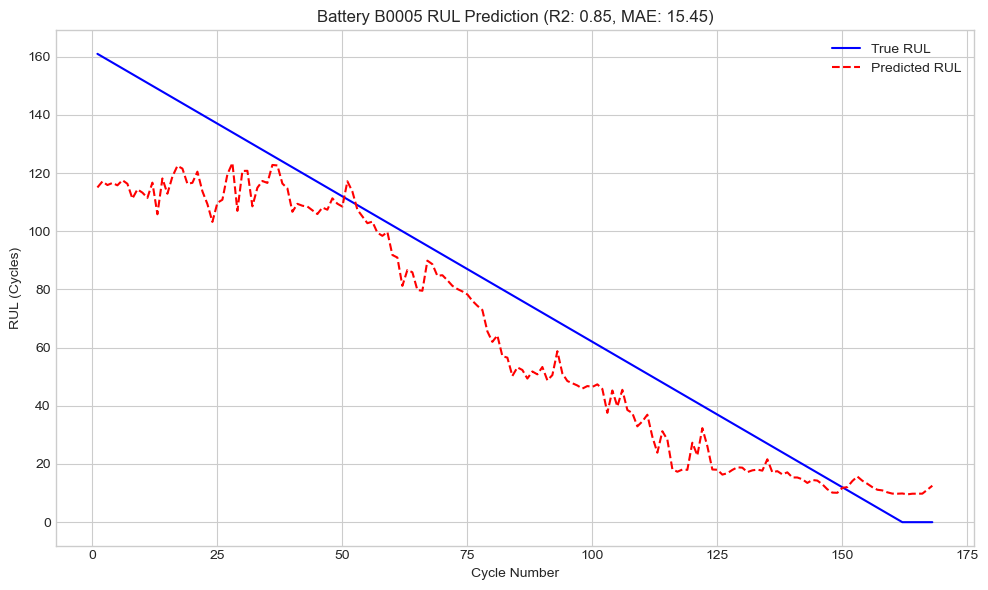


--- LOBO Fold 2/4 ---
Pin đang kiểm thử: Battery ID B0006
Số lượng mẫu huấn luyện: 468
Số lượng mẫu kiểm thử: 168
  Training time: 0.10 giây
  R-squared (Fold B0006): 0.2377
  MAE (Fold B0006): 20.4780
  RMSE (Fold B0006): 29.4092


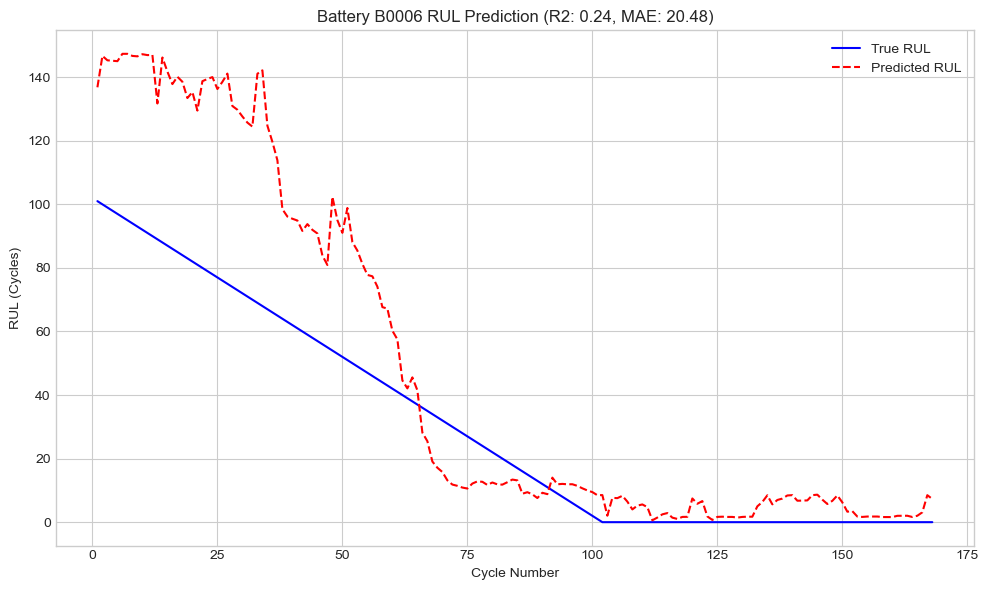


--- LOBO Fold 3/4 ---
Pin đang kiểm thử: Battery ID B0007
Số lượng mẫu huấn luyện: 468
Số lượng mẫu kiểm thử: 168
  Training time: 0.09 giây
  R-squared (Fold B0007): 0.7436
  MAE (Fold B0007): 18.6261
  RMSE (Fold B0007): 24.5582


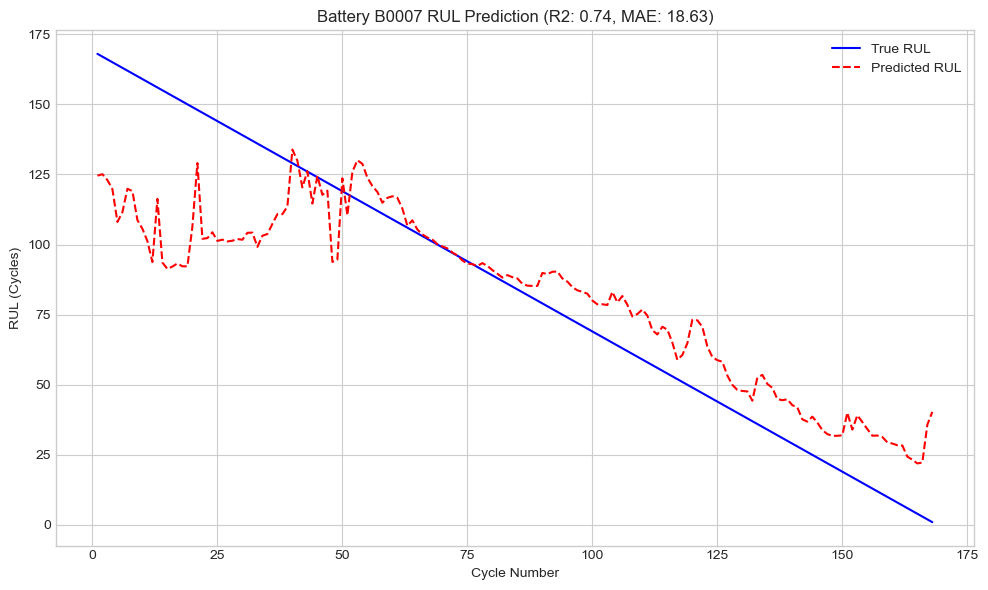


--- LOBO Fold 4/4 ---
Pin đang kiểm thử: Battery ID B0018
Số lượng mẫu huấn luyện: 504
Số lượng mẫu kiểm thử: 132
  Training time: 0.10 giây
  R-squared (Fold B0018): 0.6945
  MAE (Fold B0018): 18.6656
  RMSE (Fold B0018): 21.0598


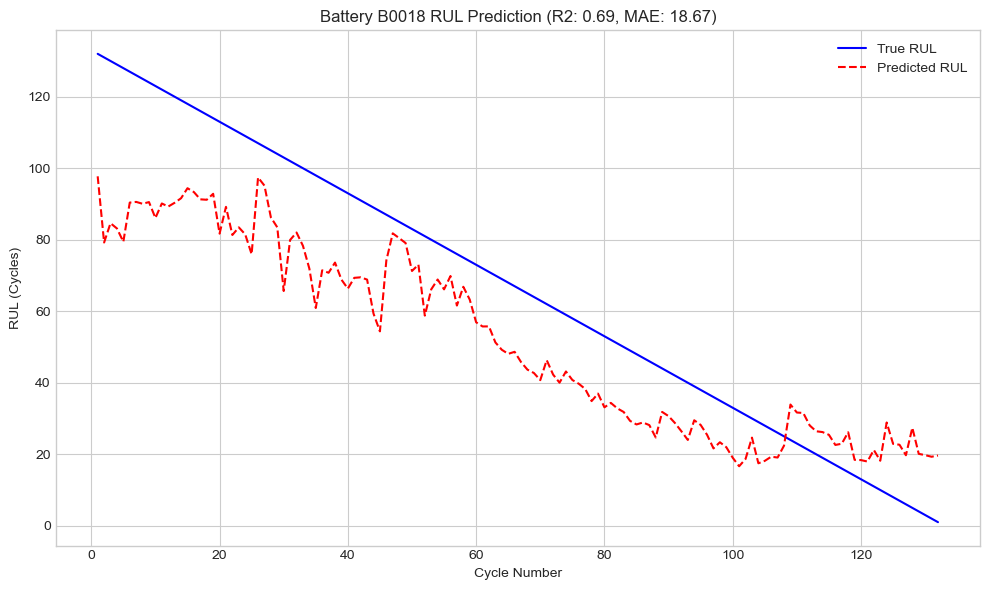


--- LOBO Cross-Validation Hoàn tất ---

--- Metrics trung bình trên các Fold ---
Average R-squared per fold: 0.6316 (Std: 0.2343)
Average MAE per fold: 18.3054 (Std: 1.8094)
Average RMSE per fold: 23.4204 (Std: 4.0450)


In [26]:
import time# Lấy danh sách ID của các viên pin duy nhất
unique_battery_ids = groups.unique()
num_batteries = len(unique_battery_ids)

print(f"Tổng số pin trong dataset: {num_batteries}")
print(f"Các đặc trưng đầu vào: {feature_columns}")
parameter = param_groups[0]['params']
# --- Khởi tạo mô hình Random Forest ---
rf_model = RandomForestRegressor(**parameter)

# --- Thực hiện LOBO Cross-Validation với LeaveOneGroupOut ---
# Khởi tạo LeaveOneGroupOut. Không cần chỉ định n_splits, nó tự động xác định từ số lượng nhóm.
logo = LeaveOneGroupOut() # <--- THAY ĐỔI Ở ĐÂY

fold_r2_scores = []
fold_mae_scores = []
fold_rmse_scores = []

print("\nBắt đầu chạy LOBO Cross-Validation...")
i = 0
# Vòng lặp vẫn tương tự, vì cả GroupKFold và LeaveOneGroupOut đều có phương thức .split()
result_stored = []
for fold_idx, (train_index, test_index) in enumerate(logo.split(X, y, groups)): # Sử dụng fold_idx để đếm fold
    # Tách dữ liệu huấn luyện và kiểm thử cho fold hiện tại
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Lấy thông tin về pin đang được kiểm thử
    current_test_battery_id = groups.iloc[test_index].unique()[0]
    current_test_cycles = df_scaled.iloc[test_index][cycle_plot_column]

    print(f"\n--- LOBO Fold {fold_idx + 1}/{num_batteries} ---") # In số fold 1-based
    print(f"Pin đang kiểm thử: Battery ID {current_test_battery_id}")
    print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")
    start_time = time.time()
    # Huấn luyện mô hình Random Forest
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_duration = end_time - start_time
    print(f"  Training time: {training_duration:.2f} giây")
    # Dự đoán trên tập kiểm thử
    y_pred = rf_model.predict(X_test)

    # Đánh giá hiệu suất cho fold hiện tại
    fold_r2 = r2_score(y_test, y_pred)
    fold_mae = mean_absolute_error(y_test, y_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    fold_r2_scores.append(fold_r2)
    fold_mae_scores.append(fold_mae)
    fold_rmse_scores.append(fold_rmse)

    print(f"  R-squared (Fold {current_test_battery_id}): {fold_r2:.4f}")
    print(f"  MAE (Fold {current_test_battery_id}): {fold_mae:.4f}")
    print(f"  RMSE (Fold {current_test_battery_id}): {fold_rmse:.4f}")

    # --- VẼ ĐỒ THỊ CHO TỪNG FOLD (TỪNG VIÊN PIN): ACTUAL vs. PREDICTED RUL ---
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plot_df = pd.DataFrame({
        'Cycle': current_test_cycles,
        'True RUL': y_test,
        'Predicted RUL': y_pred,
        'Battery': current_test_battery_id
    }).sort_values(by='Cycle')
    result_stored.append(plot_df)
    sns.lineplot(x='Cycle', y='True RUL', data=plot_df, label='True RUL', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted RUL', data=plot_df, label='Predicted RUL', color='red', linestyle='--', ax=ax)
    
    ax.set_title(f'Battery {current_test_battery_id} RUL Prediction (R2: {fold_r2:.2f}, MAE: {fold_mae:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('RUL (Cycles)')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() # Hiển thị đồ thị ngay sau mỗi fold
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ
    if i < 4:
        i += 1

print("\n--- LOBO Cross-Validation Hoàn tất ---")

# --- Chỉ hiển thị metrics trung bình trên các Fold ---
print("\n--- Metrics trung bình trên các Fold ---")
print(f"Average R-squared per fold: {np.mean(fold_r2_scores):.4f} (Std: {np.std(fold_r2_scores):.4f})")
print(f"Average MAE per fold: {np.mean(fold_mae_scores):.4f} (Std: {np.std(fold_mae_scores):.4f})")
print(f"Average RMSE per fold: {np.mean(fold_rmse_scores):.4f} (Std: {np.std(fold_rmse_scores):.4f})")

In [36]:
print(result_stored[3])

     Cycle  True RUL  Predicted RUL Battery
0        1       132          97.74   B0018
1        2       131          79.22   B0018
2        3       130          84.62   B0018
3        4       129          83.16   B0018
4        5       128          79.43   B0018
..     ...       ...            ...     ...
127    128         5          27.41   B0018
128    129         4          20.11   B0018
129    130         3          19.75   B0018
130    131         2          19.30   B0018
131    132         1          19.64   B0018

[132 rows x 4 columns]


In [37]:
result_stored[3].to_csv('./result/rul_lobo/rul_rf_b0018.csv')

# XGBoosting

In [38]:
# --- Định nghĩa 5 nhóm tham số cho XGBoost ---
param_groups_xgb = [
    {
        'name': 'Group 1: XGBoost Baseline (Defaults)',
        'params': {
            'n_estimators': 100,      # Số lượng cây (boosting rounds)
            'learning_rate': 0.1,     # Tốc độ học
            'max_depth': 3,           # Độ sâu tối đa của mỗi cây
            'subsample': 1.0,         # Tỷ lệ mẫu được lấy mẫu ngẫu nhiên cho mỗi cây
            'colsample_bytree': 1.0,  # Tỷ lệ đặc trưng được lấy mẫu ngẫu nhiên cho mỗi cây
            'gamma': 0,               # Mức giảm loss tối thiểu để thực hiện chia nút
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 2: More Estimators, Slightly Deeper Trees',
        'params': {
            'n_estimators': 300,
            'learning_rate': 0.1,
            'max_depth': 5,          # Tăng độ sâu cây
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'gamma': 0,
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 3: Slower Learning, More Trees, Subsampling',
        'params': {
            'n_estimators': 500,
            'learning_rate': 0.05,   # Giảm tốc độ học
            'max_depth': 6,
            'subsample': 0.7,        # Bắt đầu lấy mẫu hàng
            'colsample_bytree': 0.7, # Bắt đầu lấy mẫu cột
            'gamma': 0,
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 4: Stronger Regularization, More Trees',
        'params': {
            'n_estimators': 800,
            'learning_rate': 0.02,   # Học chậm hơn nữa
            'max_depth': 7,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,            # Giới thiệu gamma
            'reg_alpha': 0.005,      # Giới thiệu L1 regularization
            'reg_lambda': 0.5,       # Điều chỉnh L2 regularization
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 5: Very High Estimators & Fine-tuned',
        'params': {
            'n_estimators': 1200,    # Rất nhiều cây
            'learning_rate': 0.01,   # Rất chậm
            'max_depth': 8,          # Cho phép cây sâu hơn chút
            'subsample': 0.9,
            'colsample_bytree': 0.9,
            'gamma': 0.2,
            'reg_alpha': 0.01,
            'reg_lambda': 1.0,       # Đặt lại L2 mặc định hoặc điều chỉnh
            'random_state': 42,
            'n_jobs': -1
        }
    }
]



Bắt đầu chạy LOBO Cross-Validation...

--- LOBO Fold 1/4 ---
Pin đang kiểm thử: Battery ID B0005
Số lượng mẫu huấn luyện: 468
Số lượng mẫu kiểm thử: 168
  Training time: 0.20 giây
  R-squared (Fold B0005): 0.8297
  MAE (Fold B0005): 16.9957
  RMSE (Fold B0005): 19.9298


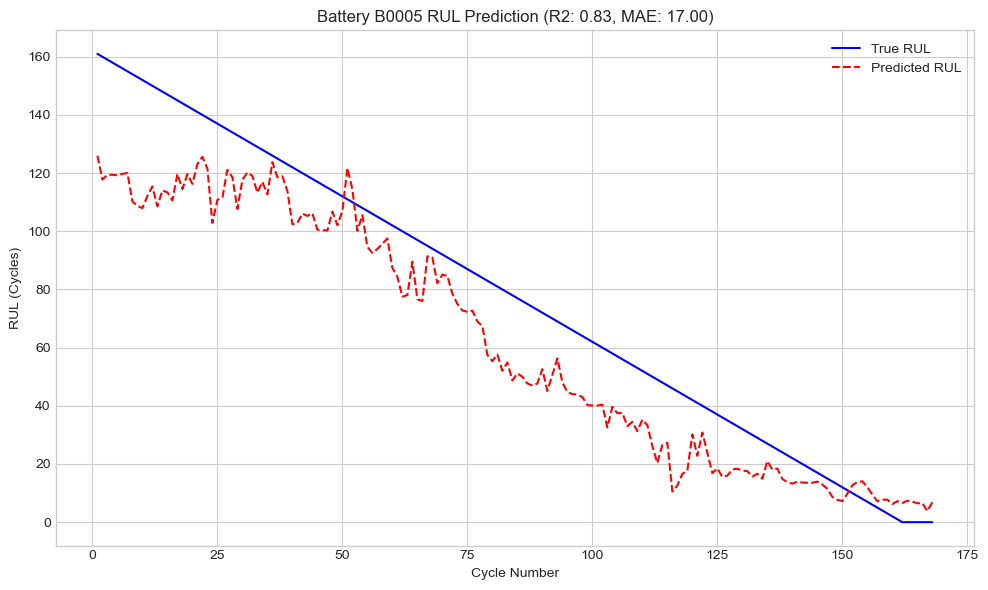


--- LOBO Fold 2/4 ---
Pin đang kiểm thử: Battery ID B0006
Số lượng mẫu huấn luyện: 468
Số lượng mẫu kiểm thử: 168
  Training time: 0.21 giây
  R-squared (Fold B0006): 0.2032
  MAE (Fold B0006): 20.3936
  RMSE (Fold B0006): 30.0675


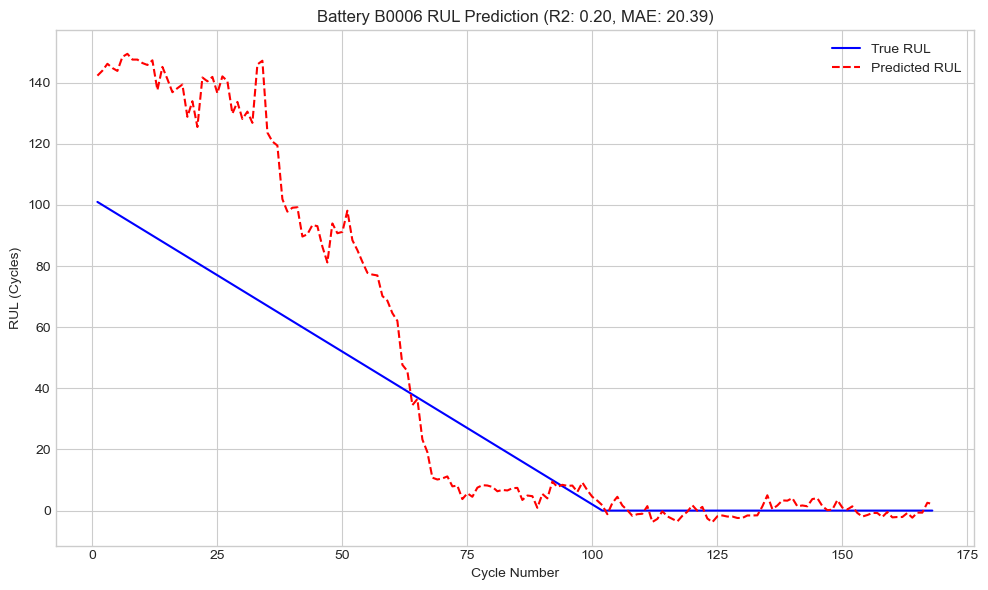


--- LOBO Fold 3/4 ---
Pin đang kiểm thử: Battery ID B0007
Số lượng mẫu huấn luyện: 468
Số lượng mẫu kiểm thử: 168
  Training time: 0.26 giây
  R-squared (Fold B0007): 0.7071
  MAE (Fold B0007): 20.1259
  RMSE (Fold B0007): 26.2448


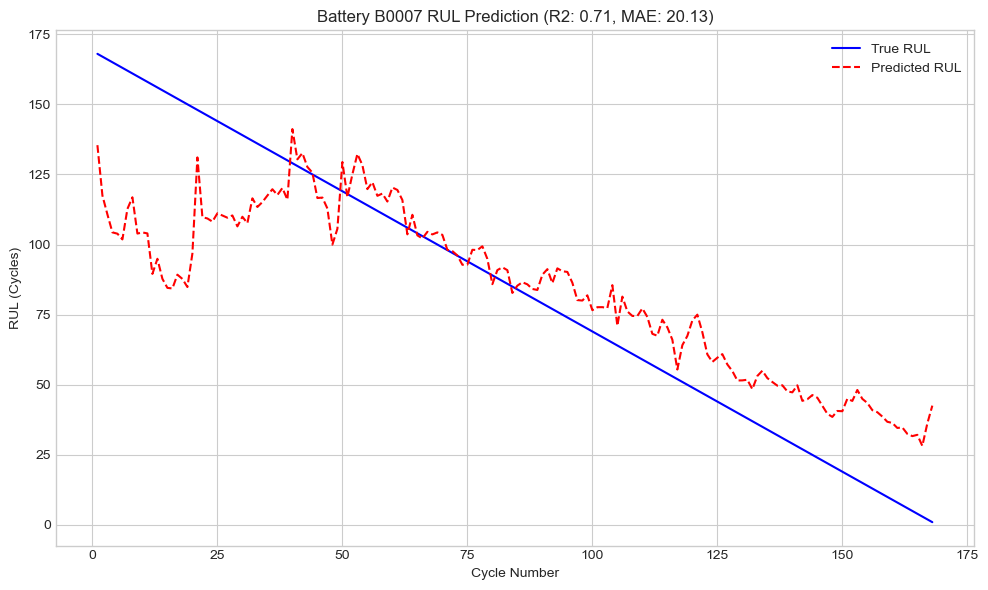


--- LOBO Fold 4/4 ---
Pin đang kiểm thử: Battery ID B0018
Số lượng mẫu huấn luyện: 504
Số lượng mẫu kiểm thử: 132
  Training time: 0.22 giây
  R-squared (Fold B0018): 0.6636
  MAE (Fold B0018): 19.0984
  RMSE (Fold B0018): 22.1009


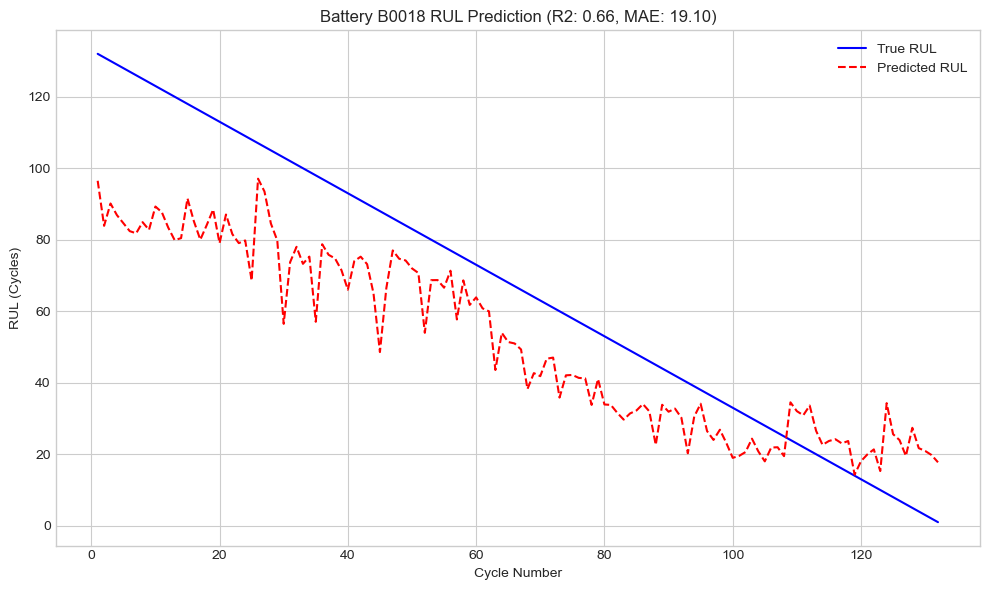


--- LOBO Cross-Validation Hoàn tất ---

--- Metrics trung bình trên các Fold ---
Average R-squared per fold: 0.6009 (Std: 0.2375)
Average MAE per fold: 19.1534 (Std: 1.3363)
Average RMSE per fold: 24.5857 (Std: 3.8940)


In [45]:
import time
parameter = param_groups_xgb[2]['params']
# --- Khởi tạo mô hình Random Forest ---
xgb_model = XGBRegressor(**parameter)

# --- Thực hiện LOBO Cross-Validation với LeaveOneGroupOut ---
# Khởi tạo LeaveOneGroupOut. Không cần chỉ định n_splits, nó tự động xác định từ số lượng nhóm.
logo = LeaveOneGroupOut() # <--- THAY ĐỔI Ở ĐÂY

fold_r2_scores = []
fold_mae_scores = []
fold_rmse_scores = []

print("\nBắt đầu chạy LOBO Cross-Validation...")
i = 0
# Vòng lặp vẫn tương tự, vì cả GroupKFold và LeaveOneGroupOut đều có phương thức .split()
result_stored_xgb = []
for fold_idx, (train_index, test_index) in enumerate(logo.split(X, y, groups)): # Sử dụng fold_idx để đếm fold
    # Tách dữ liệu huấn luyện và kiểm thử cho fold hiện tại
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Lấy thông tin về pin đang được kiểm thử
    current_test_battery_id = groups.iloc[test_index].unique()[0]
    current_test_cycles = df_scaled.iloc[test_index][cycle_plot_column]

    print(f"\n--- LOBO Fold {fold_idx + 1}/{num_batteries} ---") # In số fold 1-based
    print(f"Pin đang kiểm thử: Battery ID {current_test_battery_id}")
    print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")
    # --- ĐO THỜI GIAN HUẤN LUYỆN ---
    start_time = time.time()
    # Huấn luyện mô hình Random Forest
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_duration = end_time - start_time
    print(f"  Training time: {training_duration:.2f} giây")
    # Dự đoán trên tập kiểm thử
    y_pred = xgb_model.predict(X_test)

    # Đánh giá hiệu suất cho fold hiện tại
    fold_r2 = r2_score(y_test, y_pred)
    fold_mae = mean_absolute_error(y_test, y_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    fold_r2_scores.append(fold_r2)
    fold_mae_scores.append(fold_mae)
    fold_rmse_scores.append(fold_rmse)

    print(f"  R-squared (Fold {current_test_battery_id}): {fold_r2:.4f}")
    print(f"  MAE (Fold {current_test_battery_id}): {fold_mae:.4f}")
    print(f"  RMSE (Fold {current_test_battery_id}): {fold_rmse:.4f}")

    # --- VẼ ĐỒ THỊ CHO TỪNG FOLD (TỪNG VIÊN PIN): ACTUAL vs. PREDICTED RUL ---
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plot_df = pd.DataFrame({
        'Cycle': current_test_cycles,
        'True RUL': y_test,
        'Predicted RUL': y_pred,
        'Battery':current_test_battery_id
    }).sort_values(by='Cycle')
    result_stored_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True RUL', data=plot_df, label='True RUL', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted RUL', data=plot_df, label='Predicted RUL', color='red', linestyle='--', ax=ax)
    
    ax.set_title(f'Battery {current_test_battery_id} RUL Prediction (R2: {fold_r2:.2f}, MAE: {fold_mae:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('RUL (Cycles)')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() # Hiển thị đồ thị ngay sau mỗi fold
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ
    if i < 4: 
        i += 1
print("\n--- LOBO Cross-Validation Hoàn tất ---")

# --- Chỉ hiển thị metrics trung bình trên các Fold ---
print("\n--- Metrics trung bình trên các Fold ---")
print(f"Average R-squared per fold: {np.mean(fold_r2_scores):.4f} (Std: {np.std(fold_r2_scores):.4f})")
print(f"Average MAE per fold: {np.mean(fold_mae_scores):.4f} (Std: {np.std(fold_mae_scores):.4f})")
print(f"Average RMSE per fold: {np.mean(fold_rmse_scores):.4f} (Std: {np.std(fold_rmse_scores):.4f})")


In [48]:
print(result_stored_xgb[3])

     Cycle  True RUL  Predicted RUL Battery
300      1       101     142.307510   B0006
301      2       100     143.935852   B0006
302      3        99     146.187668   B0006
303      4        98     144.809464   B0006
304      5        97     143.853653   B0006
..     ...       ...            ...     ...
463    164         0      -2.313957   B0006
464    165         0      -0.661707   B0006
465    166         0      -0.670281   B0006
466    167         0       2.558057   B0006
467    168         0       2.168432   B0006

[168 rows x 4 columns]


In [51]:
result_stored_xgb[3].to_csv('./result/rul_lobo/rul_xgb_b0018.csv')

# STACKING ENSEMBLE

In [27]:
# --- Định nghĩa các nhóm/cấp độ siêu tham số cho từng base learner ---

param_levels = {
    'rf': {
        'simple': {
            'n_estimators': [100],
            'max_depth': [5, 10],
            'min_samples_split': [10],
            'min_samples_leaf': [5],
            'max_features': ['sqrt']
        },
        'moderate': {
            'n_estimators': [150, 200],
            'max_depth': [10, 15], # None cho phép cây phát triển đầy đủ
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt']
        },
        'complex': {
            'n_estimators': [200, 300],
            'max_depth': [15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt'] # Thử cả tỷ lệ feature
        },
        'very_complex': {
            'n_estimators': [300, 500],
            'max_depth': [20, 30],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': ['sqrt'] # 'auto' = all features
        }
    },
    'xgb': {
        'simple': {
            'n_estimators': [100],
            'learning_rate': [0.1],
            'max_depth': [3, 5],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'gamma': [0, 0.1]
        },
        'moderate': {
            'n_estimators': [150, 200],
            'learning_rate': [0.05],
            'max_depth': [5, 7],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.7, 0.8],
            'gamma': [0, 0.1],
            'reg_alpha': [0, 0.01],
            'reg_lambda': [1, 0.1] # Lambda thường > Alpha
        },
        'complex': {
            'n_estimators': [200, 300],
            'learning_rate': [0.01], # Learning rate nhỏ hơn với nhiều cây hơn
            'max_depth': [7, 9],
            'subsample': [0.6, 0.7],
            'colsample_bytree': [0.6, 0.7],
            'gamma': [0.1, 0.2],
            'reg_alpha': [0.01, 0.1],
            'reg_lambda': [0.1, 0.5]
        },
        'very_complex': {
            'n_estimators': [300, 500],
            'learning_rate': [0.01],
            'max_depth': [9, 12],
            'subsample': [0.5, 0.6],
            'colsample_bytree': [0.5, 0.6],
            'gamma': [0.2, 0.5],
            'reg_alpha': [0.1, 0.5],
            'reg_lambda': [0.5, 1]
        }
    },
    'svr': {
        'simple': {
            'C': [1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale'], # 'scale' là lựa chọn an toàn
            'epsilon': [0.1]
        },
        'moderate': {
            'C': [10, 50],
            'kernel': ['rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.01],
            'epsilon': [0.05, 0.1],
            'degree': [2, 3] # Cho poly
        },
        'complex': {
            'C': [50, 100],
            'kernel': ['rbf', 'poly'],
            'gamma': [0.001, 0.01, 0.1], # Giá trị gamma cụ thể
            'epsilon': [0.01, 0.05],
            'degree': [3, 4]
        },
        'very_complex': {
            'C': [100, 200],
            'kernel': ['rbf'], # RBF thường linh hoạt nhất
            'gamma': [0.0001, 0.001, 0.01],
            'epsilon': [0.005, 0.01],
            # 'degree' không cần nếu chỉ dùng RBF
        }
    },
    'gpr': {
        # Tinh chỉnh GPR kernel phức tạp hơn, cần định nghĩa các kernel ứng viên
        # Ở đây, chúng ta sẽ tập trung vào các tham số alpha và n_restarts
        # và giả sử bạn sẽ định nghĩa một vài kernel candidates riêng
        'simple': {
            # 'kernel': [kernel_simple_1, kernel_simple_2], # Bạn cần định nghĩa các kernel này
            'alpha': [1e-5, 1e-3],
            'n_restarts_optimizer': [5]
        },
        'moderate': {
            # 'kernel': [kernel_moderate_1, kernel_moderate_2],
            'alpha': [1e-7, 1e-5],
            'n_restarts_optimizer': [10]
        },
        'complex': {
            # 'kernel': [kernel_complex_1, kernel_complex_2],
            'alpha': [1e-9, 1e-7],
            'n_restarts_optimizer': [15]
        },
        'very_complex': {
            # 'kernel': [kernel_very_complex_1, kernel_very_complex_2],
            'alpha': [1e-10, 1e-9],
            'n_restarts_optimizer': [20]
        }
    },
    'ridge': { # Siêu tham số cho Meta-Learner (Ridge Regression)
        'simple': {'alpha': [1.0, 5.0, 10.0]},
        'moderate': {'alpha': [0.1, 0.5, 1.0, 2.0]},
        'complex': {'alpha': [0.01, 0.05, 0.1, 0.5]}, # Alpha nhỏ hơn cho phép phức tạp hơn
        'very_complex': {'alpha': [0.001, 0.005, 0.01, 0.05]}
    }
}



In [18]:

# --- Cấp độ 'simple' ---
num_features = 7
from sklearn.gaussian_process.kernels import (
    RBF,
    Matern,
    RationalQuadratic,
    ExpSineSquared,
    DotProduct,
    ConstantKernel as C, # Đổi tên để tránh nhầm lẫn với hằng số C của SVR
    WhiteKernel,
    PairwiseKernel # Cho phép sử dụng các kernel của scikit-learn như linear, rbf, poly
)
# Kernel RBF đơn giản với length_scale vô hướng (isotropic)
kernel_gpr_simple_rbf = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + \
                        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# Kernel Matern đơn giản (nu=1.5 là một lựa chọn phổ biến, ít "mượt" hơn RBF)
kernel_gpr_simple_matern = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
                           WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# --- Cấp độ 'moderate' ---
# Kernel RBF với length_scale riêng cho từng chiều (anisotropic)
# Điều này rất quan trọng nếu các feature có thang đo hoặc tầm quan trọng khác nhau.
kernel_gpr_moderate_rbf_aniso = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-2, 1e2)) + \
                                WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# Kernel Matern anisotropic
kernel_gpr_moderate_matern_aniso = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(num_features), length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
                                   WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# Kernel Rational Quadratic (có thể nắm bắt các biến đổi ở nhiều thang đo)
kernel_gpr_moderate_rq = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1, length_scale_bounds=(1e-2,1e2), alpha_bounds=(1e-2,1e2)) + \
                         WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# --- Cấp độ 'complex' ---
# Kết hợp RBF anisotropic và một kernel DotProduct (tuyến tính)
# Có thể hữu ích nếu có cả thành phần phi tuyến và tuyến tính trong dữ liệu
kernel_gpr_complex_rbf_dot = C(1.0) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-1, 1e1)) + \
                             C(1.0) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-2, 1e2)) + \
                             WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e0))

# Kernel RBF với length_scale bounds chặt hơn, cho phép tinh chỉnh kỹ hơn
kernel_gpr_complex_rbf_tight_bounds = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-1, 1e1)) + \
                                      WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e0))


# Kernel ExpSineSquared (cho dữ liệu có tính chu kỳ, có thể không phù hợp lắm với SOH trừ khi có yếu tố chu kỳ mạnh)
# Ở đây chỉ để minh họa sự đa dạng. Cần điều chỉnh `periodicity`.
# kernel_gpr_complex_expsine = C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=10.0, # periodicity cần được ước lượng từ dữ liệu
# length_scale_bounds=(1e-1,1e1), periodicity_bounds=(1.0, 50.0)
#                                                       ) + \
#                              WhiteKernel(noise_level=0.01)

# --- Cấp độ 'very_complex' ---
# Một kernel phức tạp hơn bằng cách cộng nhiều thành phần RBF với các length_scale khác nhau (ARD - Automatic Relevance Determination)
# Điều này cho phép mô hình nắm bắt các cấu trúc ở các "tần số" khác nhau.
kernel_gpr_very_complex_sum_rbf = C(1.0) * RBF(length_scale=np.ones(num_features)*0.5, length_scale_bounds=(1e-2, 1e1)) + \
                                  C(1.0) * RBF(length_scale=np.ones(num_features)*2.0, length_scale_bounds=(1e-1, 1e2)) + \
                                  WhiteKernel(noise_level=0.005, noise_level_bounds=(1e-6, 1e-1))

# Kết hợp Matern (nu=2.5, mượt hơn nu=1.5) với một thành phần tuyến tính
kernel_gpr_very_complex_matern_dot = C(1.0) * Matern(length_scale=np.ones(num_features), nu=2.5, length_scale_bounds=(1e-2, 1e1)) + \
                                     C(1.0) * DotProduct(sigma_0=0.5, sigma_0_bounds=(1e-3, 1e1)) + \
                                     WhiteKernel(noise_level=0.005, noise_level_bounds=(1e-6, 1e-1))

# Sử dụng PairwiseKernel để bọc một kernel RBF từ scikit-learn (chỉ để minh họa, thường dùng RBF trực tiếp của GPR tốt hơn)
# from sklearn.metrics.pairwise import rbf_kernel
# kernel_gpr_very_complex_pairwise = C(1.0) * PairwiseKernel(gamma=0.1, metric='rbf') + \
# WhiteKernel(noise_level=0.005)

# --- Cập nhật param_levels['gpr']['kernel'] ---
# Tạo một kernel mặc định an toàn phòng trường hợp num_features không đúng
default_gpr_kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)

if 'param_levels' not in globals(): # Nếu param_levels chưa được định nghĩa ở đâu đó
    param_levels = {'gpr': {level: {} for level in ['simple', 'moderate', 'complex', 'very_complex']}}


param_levels['gpr']['simple']['kernel'] = [kernel_gpr_simple_rbf, kernel_gpr_simple_matern]
param_levels['gpr']['moderate']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]
param_levels['gpr']['complex']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]# Bỏ ExpSine nếu không chắc
param_levels['gpr']['very_complex']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]

# Đảm bảo các cấp độ GPR khác trong param_levels cũng được khởi tạo nếu cần
for model_name in ['rf', 'xgb', 'svr', 'ridge']:
    if model_name not in param_levels:
        param_levels[model_name] = {level: {} for level in ['simple', 'moderate', 'complex', 'very_complex']}



if 'param_levels' in globals(): # Chỉ chạy nếu param_levels đã được định nghĩa
    param_levels['gpr']['simple'].update({
        'alpha': [1e-5, 1e-3],
        'n_restarts_optimizer': [5]
    })
    param_levels['gpr']['moderate'].update({
        'alpha': [1e-7, 1e-5],
        'n_restarts_optimizer': [10]
    })
    param_levels['gpr']['complex'].update({
        'alpha': [1e-9, 1e-7],
        'n_restarts_optimizer': [15]
    })
    param_levels['gpr']['very_complex'].update({
        'alpha': [1e-10, 1e-9],
        'n_restarts_optimizer': [20]
    })

    # In ra để kiểm tra một cấp độ
    print("\nVí dụ tham số GPR 'moderate' sau khi thêm kernel và alpha/n_restarts:")
    print(param_levels['gpr']['moderate'])

else:
    print("Cảnh báo: 'param_levels' chưa được định nghĩa. Không thể cập nhật alpha và n_restarts cho GPR.")


Ví dụ tham số GPR 'moderate' sau khi thêm kernel và alpha/n_restarts:
{'alpha': [1e-07, 1e-05], 'n_restarts_optimizer': [10], 'kernel': [1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.05), 1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=0.05), 1**2 * RationalQuadratic(alpha=0.1, length_scale=1) + WhiteKernel(noise_level=0.05)]}


In [19]:

# --- BƯỚC 1: KHỞI TẠO BASE LEARNERS (CHỈ LÀ TEMPLATE BAN ĐẦU) ---
rf_model_template = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb_model_template = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
svr_model_template = SVR()
gpr_model_template = GaussianProcessRegressor(random_state=42) # Kernel sẽ được set bởi GridSearchCV

base_learner_templates = [ # Danh sách các template ban đầu
    ('rf', rf_model_template),
    ('xgb', xgb_model_template),
    ('svr', svr_model_template),
    ('gpr', gpr_model_template)
]
# Nếu không có feature, loại bỏ GPR
if num_features == 0 and 'gpr' in [name for name,_ in base_learner_templates]:
    base_learner_templates = [tpl for tpl in base_learner_templates if tpl[0] != 'gpr']
    print("CẢNH BÁO: GPR đã bị loại bỏ do không có features.")

In [28]:
# --- BƯỚC 2: TẠO OUT-OF-FOLD (OOF) PREDICTIONS VỚI GridSearchCV (NESTED CV) ---
logo_outer = LeaveOneGroupOut() # Outer loop: LOBO theo pin
n_outer_splits = logo_outer.get_n_splits(groups=groups)

oof_predictions_base = np.zeros((len(X), len(base_learner_templates)))
oof_true_targets_for_meta = np.zeros(len(X))
best_params_per_fold_learner = [] # Lưu trữ best_params cho từng base learner ở mỗi outer fold

# CHỌN CẤP ĐỘ THAM SỐ ĐỂ THỬ NGHIỆM (ví dụ: chỉ 'simple' để chạy nhanh)
# Nếu muốn thử tất cả: levels_to_try = ['simple', 'moderate', 'complex', 'very_complex']
current_level_to_try = 'simple'
print(f"\n--- SỬ DỤNG CẤP ĐỘ THAM SỐ: {current_level_to_try.upper()} ---")


print(f"\nBắt đầu quá trình Nested LOBO với {n_outer_splits} pin (Outer Loop)...")
start_time_total_lobo = time.time()
i = 0
for fold_idx_outer, (train_idx_outer, val_idx_outer) in enumerate(logo_outer.split(X, y, groups)):
    X_train_outer, X_val_outer = X.iloc[train_idx_outer], X.iloc[val_idx_outer]
    y_train_outer, y_val_outer = y.iloc[train_idx_outer], y.iloc[val_idx_outer]
    groups_train_outer = groups.iloc[train_idx_outer] # Groups cho inner CV
    current_val_battery_id = groups.iloc[val_idx_outer].unique()[0]
    
    print(f"\n  Outer Fold {fold_idx_outer + 1}/{n_outer_splits} - Pin VAL: {current_val_battery_id}")
    oof_true_targets_for_meta[val_idx_outer] = y_val_outer.values

    for i_learner, (learner_name, model_template) in enumerate(base_learner_templates):
        start_time_learner_fold = time.time()
        print(f"    Tinh chỉnh và huấn luyện Base Learner: {learner_name}")

        # Lấy param grid cho learner và level hiện tại
        if learner_name not in param_levels or current_level_to_try not in param_levels[learner_name]:
            print(f"Cảnh báo: Không tìm thấy param grid cho {learner_name} ở level {current_level_to_try}. Bỏ qua.")
            oof_predictions_base[val_idx_outer, i_learner] = np.nan # Gán NaN nếu không có param grid
            continue

        param_grid_learner = param_levels[learner_name][current_level_to_try]

        # Inner CV: GroupKFold nếu có nhiều hơn 1 pin trong X_train_outer, ngược lại KFold
        # Giảm số fold của inner CV để chạy nhanh hơn khi test
        n_inner_cv_splits = min(3, len(groups_train_outer.unique())) if len(groups_train_outer.unique()) > 1 else 2
        if len(groups_train_outer.unique()) > 1 :
            inner_cv = GroupKFold(n_splits=n_inner_cv_splits)
            print(f"Inner CV: GroupKFold với {n_inner_cv_splits} splits")
            current_groups_for_inner_cv = groups_train_outer
        else: # Nếu X_train_outer chỉ còn dữ liệu từ 1 pin hoặc không có group info rõ ràng
            inner_cv = KFold(n_splits=n_inner_cv_splits, shuffle=True, random_state=42)
            print(f"Inner CV: KFold với {n_inner_cv_splits} splits")
            current_groups_for_inner_cv = None # KFold không cần groups


        # GridSearchCV cho base learner hiện tại
        # Giảm verbosity và n_jobs để tránh quá nhiều output khi test
        grid_search_cv = GridSearchCV(
            estimator=clone(model_template), # Quan trọng: clone template
            param_grid=param_grid_learner,
            scoring='neg_root_mean_squared_error', # Hoặc 'r2'
            cv=inner_cv,
            n_jobs=1, # Đặt là 1 để dễ debug, tăng lên nếu muốn song song
            verbose=0 # Đặt là 1 hoặc 2 để xem chi tiết hơn
        )

        try:
            if X_train_outer.empty and learner_name == 'gpr':
                raise ValueError("X_train_outer rỗng cho GPR.")
            grid_search_cv.fit(X_train_outer, y_train_outer, groups=current_groups_for_inner_cv)

            best_model_for_fold = grid_search_cv.best_estimator_
            fold_preds = best_model_for_fold.predict(X_val_outer)
            oof_predictions_base[val_idx_outer, i_learner] = fold_preds

            print(f"Best params cho {learner_name}: {grid_search_cv.best_params_}")
            print(f"Best CV score (neg_RMSE): {grid_search_cv.best_score_:.4f}")
            best_params_per_fold_learner.append({
                'outer_fold': fold_idx_outer + 1,
                'learner': learner_name,
                'best_params': grid_search_cv.best_params_,
                'best_cv_score': grid_search_cv.best_score_
            })

        except Exception as e:
            print(f"LỖI với GridSearchCV cho {learner_name}: {e}")
            oof_predictions_base[val_idx_outer, i_learner] = np.nan # Gán NaN nếu GridSearch lỗi

        end_time_learner_fold = time.time()
        print(f"Thời gian cho {learner_name} ở fold này: {end_time_learner_fold - start_time_learner_fold:.2f} giây")
    if i < 4: 
        i += 1


end_time_total_lobo = time.time()
print(f"\nHoàn thành tạo OOF predictions với GridSearchCV. Tổng thời gian: {end_time_total_lobo - start_time_total_lobo:.2f} giây")

best_params_df = pd.DataFrame(best_params_per_fold_learner)
print("\n--- Siêu tham số tốt nhất cho Base Learners ở mỗi Outer Fold ---")
print(best_params_df)


meta_features_from_oof = pd.DataFrame(oof_predictions_base, columns=[name for name, _ in base_learner_templates])
for col in meta_features_from_oof.columns: # Xử lý NaN
    if meta_features_from_oof[col].isnull().any():
        print(f"Cảnh báo: Tìm thấy NaN trong OOF predictions của {col}. Điền bằng giá trị trung bình.")
        if not meta_features_from_oof[col].isnull().all():
            meta_features_from_oof[col].fillna(meta_features_from_oof[col].mean(), inplace=True)
        else:
            meta_features_from_oof[col].fillna(0, inplace=True)

meta_target_for_training = pd.Series(oof_true_targets_for_meta, name=target_column)


--- SỬ DỤNG CẤP ĐỘ THAM SỐ: SIMPLE ---

Bắt đầu quá trình Nested LOBO với 4 pin (Outer Loop)...

  Outer Fold 1/4 - Pin VAL: B0005
    Tinh chỉnh và huấn luyện Base Learner: rf
Inner CV: GroupKFold với 3 splits
Best params cho rf: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best CV score (neg_RMSE): -30.0218
Thời gian cho rf ở fold này: 0.82 giây
    Tinh chỉnh và huấn luyện Base Learner: xgb
Inner CV: GroupKFold với 3 splits
Best params cho xgb: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV score (neg_RMSE): -32.8440
Thời gian cho xgb ở fold này: 0.64 giây
    Tinh chỉnh và huấn luyện Base Learner: svr
Inner CV: GroupKFold với 3 splits
Best params cho svr: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score (neg_RMSE): -27.6635
Thời gian cho svr ở fold này: 0.18 giây
    Tinh chỉnh và huấn luyện Base Learner: gpr
Inner C

In [29]:
# --- BƯỚC 3: TINH CHỈNH SIÊU THAM SỐ CHO META-LEARNER (Ridge Regression) ---
print("\n--- Tinh chỉnh siêu tham số cho Meta-Learner (Ridge) ---")
meta_learner_template = Ridge(random_state=42)
param_grid_meta = param_levels['ridge'][current_level_to_try] # Lấy alpha grid cho level hiện tại

# CV cho meta-learner: có thể dùng KFold hoặc LOBO (nếu muốn chặt chẽ)
# Ở đây dùng LOBO để nhất quán
# Chú ý: groups ở đây là groups gốc, tương ứng với thứ tự của meta_features_from_oof
cv_meta = LeaveOneGroupOut()
# Hoặc KFold đơn giản hơn: cv_meta = KFold(n_splits=min(5, n_outer_splits), shuffle=True, random_state=42)


grid_search_meta = GridSearchCV(
    estimator=meta_learner_template,
    param_grid=param_grid_meta,
    scoring='neg_root_mean_squared_error',
    cv=cv_meta, # Sử dụng LOBO với groups gốc
    n_jobs=1,
    verbose=1
)

grid_search_meta.fit(meta_features_from_oof, meta_target_for_training, groups=groups) # Truyền groups cho LOBO

best_meta_learner = grid_search_meta.best_estimator_
print(f"\nMeta-Learner tốt nhất: {best_meta_learner}")
print(f"Hệ số của Meta-Learner tốt nhất: {best_meta_learner.coef_}")
print(f"Best CV score (neg_RMSE) cho Meta-Learner: {grid_search_meta.best_score_:.4f}")


# --- BƯỚC 4: ĐÁNH GIÁ MÔ HÌNH STACKING VỚI META-LEARNER ĐÃ TINH CHỈNH ---
# Dự đoán trên OOF data bằng meta-learner tốt nhất
stacking_oof_predictions = best_meta_learner.predict(meta_features_from_oof)
oof_rmse_stacking = np.sqrt(mean_squared_error(meta_target_for_training, stacking_oof_predictions))
oof_r2_stacking = r2_score(meta_target_for_training, stacking_oof_predictions)
oof_mae_stacking = mean_absolute_error(meta_target_for_training, stacking_oof_predictions)
print(f"\n--- Chỉ số đánh giá của Mô hình STACKING (với Meta-Learner đã tinh chỉnh) trên OOF predictions ---")
print(f"  RMSE: {oof_rmse_stacking:.4f}")
print(f"  R2 score: {oof_r2_stacking:.4f}")
print(f"  MAE: {oof_mae_stacking:.4f}")


--- Tinh chỉnh siêu tham số cho Meta-Learner (Ridge) ---
Fitting 4 folds for each of 3 candidates, totalling 12 fits

Meta-Learner tốt nhất: Ridge(random_state=42)
Hệ số của Meta-Learner tốt nhất: [ 1.32957998 -0.83754327  0.42839649  0.10868811]
Best CV score (neg_RMSE) cho Meta-Learner: -29.3639

--- Chỉ số đánh giá của Mô hình STACKING (với Meta-Learner đã tinh chỉnh) trên OOF predictions ---
  RMSE: 22.0532
  R2 score: 0.7879
  MAE: 16.0696


In [57]:
print(type(stacking_oof_predictions))
stacking_oof_predictions [stacking_oof_predictions < 0] =  0

<class 'numpy.ndarray'>


R-squared: 0.8811
MAE: 11.5126
RMSE: 13.1369
R-squared: 0.7891
MAE: 17.0758
RMSE: 22.2729
R-squared: 0.8508
MAE: 14.7195
RMSE: 18.6520
R-squared: 0.2407
MAE: 19.9939
RMSE: 29.3527


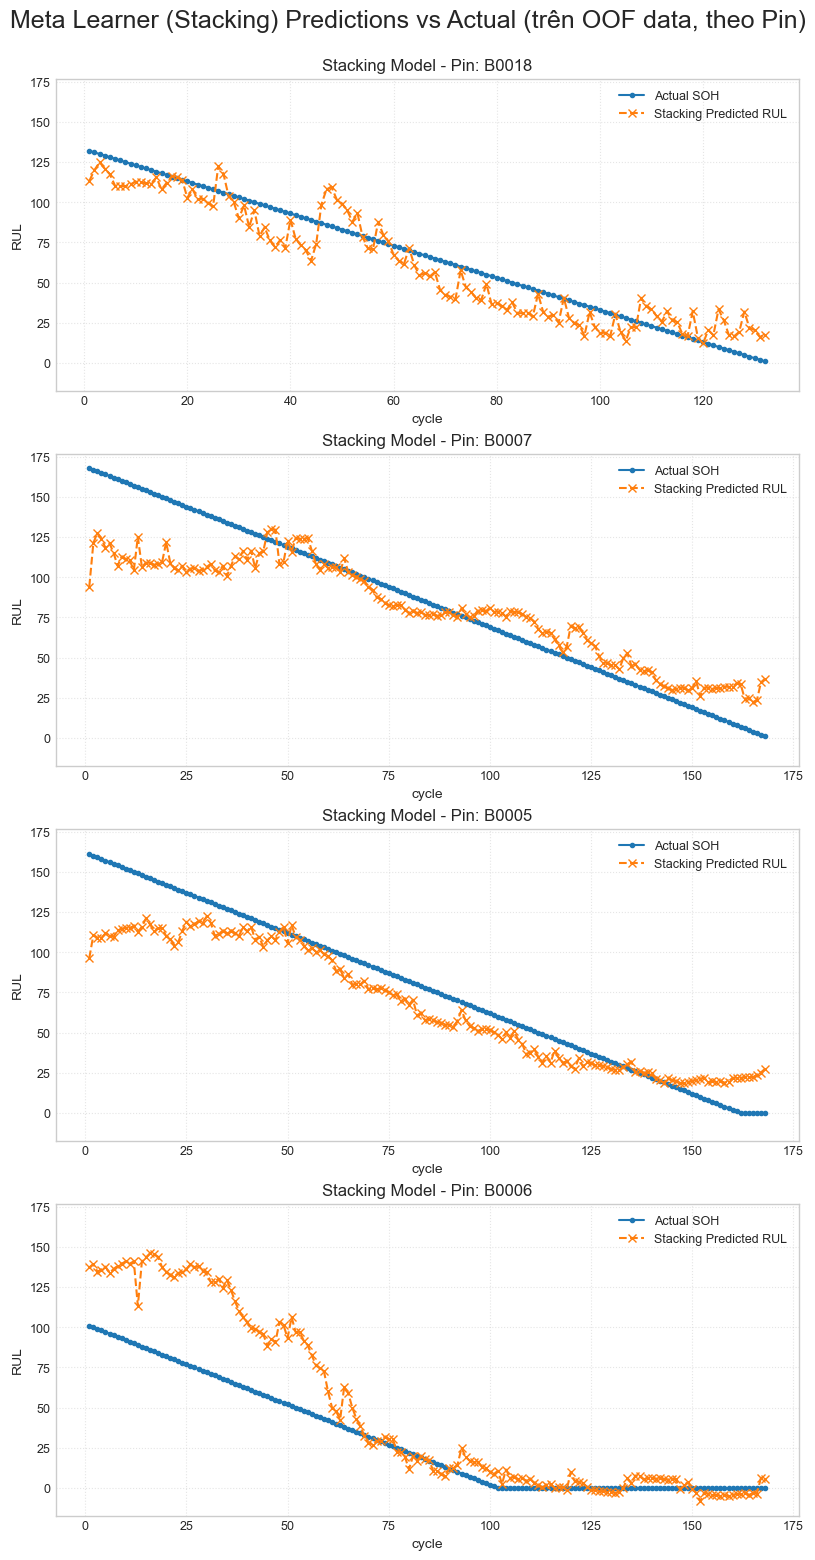

In [30]:

# Vẽ đồ thị cho meta-learner (giữ nguyên phần này vì nó hữu ích)
fig_meta_learner, axes_meta_learner = plt.subplots(n_outer_splits, 1,
                                                   figsize=(8, 15),
                                                   sharey=True, constrained_layout=True)
if n_outer_splits == 1:
    axes_meta_learner = [axes_meta_learner]
fig_meta_learner.suptitle('Meta Learner (Stacking) Predictions vs Actual (trên OOF data, theo Pin)', fontsize=18, y=1.03)
unique_batteries = groups.unique()
result_stored_st = []
for i, battery_id_to_plot in enumerate(unique_batteries):
    battery_mask = (groups == battery_id_to_plot).values
    x_plot_values_batt = df_scaled[battery_mask][cycle_plot_column].values
    actual_batt = meta_target_for_training[battery_mask]
    predicted_batt_stacking = stacking_oof_predictions[battery_mask]
    data_plot = pd.DataFrame({
        'Battery': battery_id_to_plot, 
        'RUL_actual': actual_batt,
        'RUL_predicted': predicted_batt_stacking
    })
    result_stored_st.append(data_plot)
    # Tính R-squared
    r2 = r2_score(actual_batt, predicted_batt_stacking)

    # Tính MAE
    mae = mean_absolute_error(actual_batt, predicted_batt_stacking)

    # Tính RMSE
    rmse = mean_squared_error(actual_batt, predicted_batt_stacking, squared=False)

    print(f"R-squared: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    ax_meta = axes_meta_learner[i]
    ax_meta.plot(x_plot_values_batt, actual_batt, label='Actual SOH', marker='.', linestyle='-', markersize=6)
    ax_meta.plot(x_plot_values_batt, predicted_batt_stacking, label='Stacking Predicted RUL', marker='x', linestyle='--', markersize=6)
    ax_meta.set_title(f'Stacking Model - Pin: {battery_id_to_plot}', fontsize=12)
    ax_meta.set_xlabel(cycle_plot_column, fontsize=10)
    ax_meta.set_ylabel('RUL', fontsize=10)
    ax_meta.legend(fontsize=9)
    ax_meta.grid(True, linestyle=':', alpha=0.5)
    ax_meta.tick_params(axis='both', which='major', labelsize=9)

In [32]:
print(result_stored_st[2])

    Battery  RUL_actual  RUL_predicted
300   B0005       161.0      96.384663
301   B0005       160.0     110.684444
302   B0005       159.0     109.163617
303   B0005       158.0     108.848652
304   B0005       157.0     111.729289
..      ...         ...            ...
463   B0005         0.0      22.649071
464   B0005         0.0      22.313793
465   B0005         0.0      23.649743
466   B0005         0.0      25.181478
467   B0005         0.0      27.449306

[168 rows x 3 columns]


In [33]:
result_stored_st[2].to_csv('./result/rul_lobo/rul_st_b0005.csv')